In [1]:
# Installing deskwew for deskewing the image
!pip install deskew

In [2]:
# All the required imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.models import load_model
from skimage.transform import rotate
from deskew import determine_skew

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reads an image and returns an image as a 2d numpy array.
def read_image(path):
    return np.asarray(Image.open(path).convert('L'))

Binarization is converting the image pixels to just have values 0 and 1. We have used Otsu's thresholding together with binary.

In [5]:
# Binarizes an image.The input is a 2d numpy array.
def Binarize_image(img):
    # Apply Gaussian filtering 
    filtered_img = cv2.GaussianBlur(img,(5,5),0)
    # Apply thresholding.Otsu's and binary.
    ret,Thresh_img = cv2.threshold(filtered_img,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    return Thresh_img
    

Text in the image should not be tilted with respect to the image. Such a tilt would effect the process of text recognition. Correction of this tilt by rotating the image in opposite direction is called **skew correction**. 

In [6]:
# Expects a binarized image as input
def skew_corrected_img(img):
    angle = determine_skew(img)
    return rotate(img,angle,resize=True,mode='edge')*255

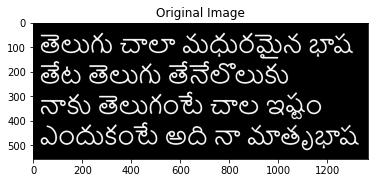

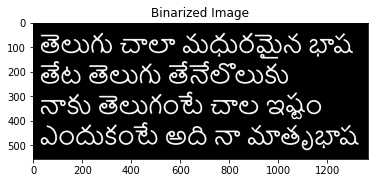

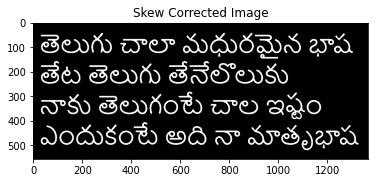

In [7]:
# Change the path of the image file appropreatily.
img = read_image('/content/drive/MyDrive/18084_18277_FP/Project_files/Img2.png')
plt.imshow(img,cmap='Greys')
plt.title('Original Image')
plt.show()

img = Binarize_image(img)
plt.imshow(img,cmap='Greys')
plt.title('Binarized Image')
plt.show()

img = skew_corrected_img(img)
plt.imshow(img,cmap='Greys')
plt.title('Skew Corrected Image')

plt.show()

Splitting the images into lines. Line level segmentation.

In [8]:
# For splitting the image into lines.

# Function for distance
def split_lines_d(img):
    x=[]
    start = 0
    stop = 0
    for i in range(len(img)-1):
        if np.count_nonzero(img[i]==0) > 0 and np.count_nonzero(img[i-1]==0) == 0 :
            start = i
        #if i!=len(img)-1:
        if np.count_nonzero(img[i]==0) > 0 and np.count_nonzero(img[i+1]==0) == 0 :
            stop = i
            x.append(stop-start)      
    return x

def min_dist(img):
  splited_dist = split_lines_d(img)
  sort_dist=sorted(splited_dist)
  diff=[]
  for i in range(len(sort_dist)-1):
    z=sort_dist[i+1]-sort_dist[i]
    diff.append([z,sort_dist[i]])
  diff2=sorted(diff)
  if diff2[-1][0]<sort_dist[0]:
    dist=sort_dist[0]-2
  else:
    dist=diff2[-1][1]
  return dist

def split_lines_k(img):
    x=[]
    start = 0
    stop = 0
    for i in range(len(img)-1):
        if np.count_nonzero(img[i]==0) > 0 and np.count_nonzero(img[i-1]==0) == 0 :
            start = i
        #if i!=len(img)-1:
        if np.count_nonzero(img[i]==0) > 0 and np.count_nonzero(img[i+1]==0) == 0 :
            stop = i
            x.append([stop,start])
    return x

def forming_lines(img):
  new=[]
  img2=split_lines_k(img)
  new.append([img2[0][1],img2[0][0]])
  for i in range(len(img2)-1):
    if img2[i+1][0]-img2[i+1][1]<=min_dist(img):
      if new[-1][0]==img2[i][1]:
        new[-1][1]=img2[i+1][0]
      else:
        new.append([img2[i][1],img2[i+1][0]])
    else:
      new.append([img2[i+1][1],img2[i+1][0]])
  return new
  

def split_lines(img):
  line_images=[]
  points=forming_lines(img)
  for i in points:
    start=i[0]
    stop=i[1]
    line_images.append(img[start:stop+1])
  return line_images

In [9]:
lines = split_lines(img)

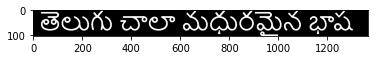

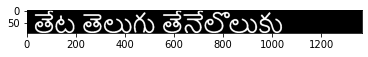

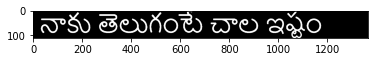

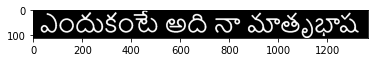

In [10]:
for i in lines:
    plt.imshow(i,cmap='Greys')
    plt.show()

Word Level Segmentation of lines.

In [11]:
def split_line(img):
    # Outputs an array containing no. of zeroes in each row
    def num_zero(img):
        temp_list = []
        for i in range(len(img)):
            temp_list.append(np.count_nonzero(img[i]==0))
        return np.array(temp_list)
    
    # Image to be trimmed at the top and bottom. 
    # arr argument is the array containing no. of zeroes in each row
    def trim_image(img,arr):
        start = 0
        stop = 0
        for i in range(len(arr)):
            if arr[i]!=0:
                start = i
                break
        for i in reversed(range(len(arr))):
            if arr[i] != 0:
                stop = i
                break
        return (img[start:stop+1],arr[start:stop+1])

    
    # Returns length of consecutive zeroes
    def length(arr,ind,ele):
        if ind != len(arr)-1:
            i = ind
            while i<=len(arr)-1 and arr[i]==ele:
                i+=1
                
            if i != ind:
                return i-ind
            else:
                return 1
        else:
            return 

    # Returns True if no word exists after the current row.
    def EOL(arr,ind,ele):
        temp = True
        for i in range(ind,len(arr)):
            if arr[i] != 0:
                temp = False
        return temp

    # Returns the length above which the image should be split
    # The argument is the array of no. of zeroes
    def limiting_length(arr):
        temp_list = []
        i=0
        while i< len(arr):
            temp=0
            if arr[i] == 0:
                temp = length(arr,i,0)
                temp_list.append(temp)
            i=i+temp+1

        # maximum difference between consecutive elements
        temp_list.sort()
        diff = 0
        lim_len = 0
        for i in range(1,len(temp_list)):
            temp = temp_list[i] - temp_list[i-1]
            if temp > diff:
                diff = temp
                lim_len = temp_list[i-1]
        return lim_len
    
    img = np.transpose(img)
    zeroes = num_zero(img)
    trim_img, zeroes = trim_image(img,zeroes) 
    limit_len = limiting_length(zeroes)
    splited_images = []
    start = 0
    stop = 0
    i=1
    
    while i<len(zeroes):
        if zeroes[i] != 0:
            start = i
            while i < len(zeroes):
                if zeroes[i]!=0:
                    i+=1
                else:
                    if length(zeroes,i,0) > limit_len:
                        break
                    else:
                        i+=length(zeroes,i,0)
            if length(zeroes,i,0) > limit_len or EOL(zeroes,i,0):
                stop = i
                temp_img = np.transpose(trim_img[start:stop])
                splited_images.append(temp_img)
                i+=limit_len
        else:
            i+=1
    return splited_images

In [12]:
words = split_line(lines[0])

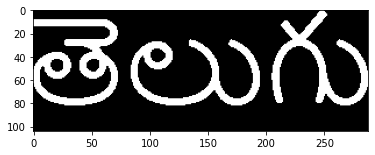

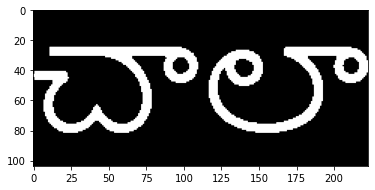

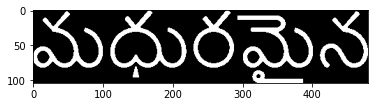

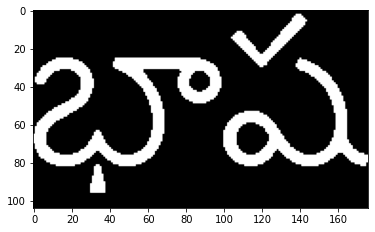

In [13]:
for word in words:
    plt.imshow(word,cmap='Greys')
    plt.show()

In [14]:
def split_word(img1):
    img = np.transpose(img1)
    splitted_letters = []
    i=0
    while i < len(img):
        if np.count_nonzero(img[i]==0) != 0:
            start = i
            j=i+1
            while j < len(img):
                if np.count_nonzero(img[j]==0) == 0:
                    break
                j+=1
            temp_img = np.transpose(img[start:j])
            splitted_letters.append(temp_img)
            i=j
        else:
            i+=1
    return splitted_letters

In [15]:
letters = split_word(words[0])

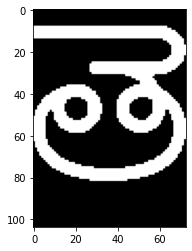

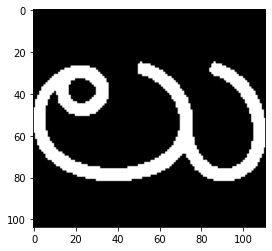

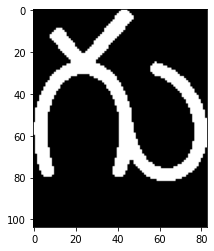

In [16]:
for i in letters:
    plt.imshow(i,cmap='Greys')
    plt.show()

# PART-2 : PREDICTION OF CHARACTER

In [17]:
# Load the models for prediction of character.
from keras.models import load_model
from keras.models import model_from_json
import json
with open('/content/drive/MyDrive/18084_18277_FP/Project_files/Training/model_chars_tccnn-l.json') as infile:
    json_char = json.load(infile)

model_1 = model_from_json(json_char)
model_1.load_weights('/content/drive/MyDrive/18084_18277_FP/Project_files/Training/model_chars_tccnn-l.hdf5')

with open('/content/drive/MyDrive/18084_18277_FP/Project_files/Training/model_v_g.json') as infile:
    json_char = json.load(infile)

model_2 = model_from_json(json_char)
model_2.load_weights('/content/drive/MyDrive/18084_18277_FP/Project_files/Training/model_v_g_weights.hdf5')

In [18]:
#FUNCTION
def predict_from_char(char):
  img=char
  #img=cv2.transpose(img)
  img=cv2.resize(img,(32,32))
  img = np.asarray(img).reshape(1,1,32,32)
  img = img.astype('float32')
  img = img/255.0
  chars=[]
  vg=[]
  out =  model_1.predict(img)
  chars.append(np.where(out==out.max())[1][:]+1)
  if np.where(out==out.max())[1][:]+1>=20 and np.where(out==out.max())[1][:]+1<=55:
    out2 = model_2.predict(img)
    vg.append(np.where(out2==out2.max())[1][:])
  else:
    vg.append(np.array([-1]))
  return chars[0][0],vg[0][0]

In [20]:
# Change the path of the image accordingly.
img = read_image('/content/drive/MyDrive/18084_18277_FP/Project_files/Img2.png')
img = Binarize_image(img)
img = skew_corrected_img(img)

In [21]:
f1 = open('/content/drive/MyDrive/18084_18277_FP/Project_files/char.txt','r')
temp_list = f1.readlines()
f1.close()
char = {}
i=0
for i in range(len(temp_list)):
    if i%2 == 0:
        char[(i/2)+1] = temp_list[i+1] 

f2 = open('/content/drive/MyDrive/18084_18277_FP/Project_files/vattu_gunintam.txt','r')
temp_list = f2.readlines()
f2.close()
vattu_gunintam={}
i=0
for i in range(len(temp_list)):
    if i%2 == 0:
        vattu_gunintam[(i/2)] = temp_list[i+1]


f = open('/content/drive/MyDrive/18084_18277_FP/Project_files/output.html','w')

for line in split_lines(img):
    for word in split_line(line):
        for letter in split_word(word):
            a,b = predict_from_char(letter)
            if b==-1:
                f.write(char[a][:-2])
            else:
                f.write(char[a][:-2]+vattu_gunintam[b][:-2])
        f.write('&nbsp;')
    f.write('<br />')

f.close()